In [293]:
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    MinMaxScaler
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [294]:
df_raw = pd.read_csv('/workspaces/time_series_2/data/raw/Water_Spring_Madonna_di_Canneto.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          3104 non-null   object 
 1   Rainfall_Settefrati           2557 non-null   float64
 2   Temperature_Settefrati        2557 non-null   float64
 3   Flow_Rate_Madonna_di_Canneto  1387 non-null   float64
dtypes: float64(3), object(1)
memory usage: 97.4+ KB


# Quick intro

I picked this data set because it has variables that actually make sense to me. 
  
the others, have data that I can see got removed from other's code, but I don't have documentation on why. I did research on them, but they do not have any info online.  

Example: in Aquafier Petrignano, has 2 targets, ground water p24, and p25, each pertaining to different wells, but don't say which is which, and some notebooks dropped one. I could copy them, but I would rather make decisions on what I understand.  
  
This data set has simple, straightforward variables, so I went with this one.  
  
  ### Spring Madonna
  

In [295]:
df_raw.sample(10,random_state=2025)

,Date,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
1194,09/04/2015,0.0,9.35,261.890342
1092,28/12/2014,10.2,1.95,NaN
2852,23/10/2019,NaN,NaN,221.747999
1102,07/01/2015,0.0,0.20,NaN
1403,04/11/2015,0.0,13.85,NaN
2114,15/10/2017,0.0,18.60,214.986150
3021,09/04/2020,NaN,NaN,224.550259
3084,11/06/2020,NaN,NaN,224.446045
4,05/01/2012,1.0,5.55,NaN
915,04/07/2014,0.0,23.60,NaN


In [296]:
df_baking = df_raw.copy()

df_baking = df_baking[df_baking['Flow_Rate_Madonna_di_Canneto'].notna()] # ----- Dropped null variables for only flow rate
df_baking.columns = df_baking.columns.str.lower()
df_baking['date'] = pd.to_datetime(df_baking['date'])





df = df_baking.copy() # Time series DF
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index) 
df.info()
df_baking.info()

df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2015-03-13 to 2020-06-30
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   rainfall_settefrati           879 non-null    float64
 1   temperature_settefrati        879 non-null    float64
 2   flow_rate_madonna_di_canneto  1387 non-null   float64
dtypes: float64(3)
memory usage: 43.3 KB
<class 'pandas.core.frame.DataFrame'>
Index: 1387 entries, 1167 to 3103
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          1387 non-null   datetime64[ns]
 1   rainfall_settefrati           879 non-null    float64       
 2   temperature_settefrati        879 non-null    float64       
 3   flow_rate_madonna_di_canneto  1387 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
me

/tmp/ipykernel_16163/4205584666.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_baking['date'] = pd.to_datetime(df_baking['date'])


,rainfall_settefrati,temperature_settefrati,flow_rate_madonna_di_canneto
date,,,
2015-03-13,0.0,5.70,255.956525
2015-03-14,5.8,7.10,289.545561
2015-03-15,7.4,4.90,289.918615
2015-03-16,8.6,7.50,290.082896
2015-03-17,7.6,7.55,290.688777
...,...,...,...
2020-06-26,NaN,NaN,223.919115
2020-06-27,NaN,NaN,223.861787
2020-06-28,NaN,NaN,223.764382


Dropped null variables for only flow rate, because that can still have coorelation to a season/time, where as the others are good variables to have, but aren't as important as the actual flow rate, which is the target

In [297]:
print(df.columns)


Index(['rainfall_settefrati', 'temperature_settefrati',
       'flow_rate_madonna_di_canneto'],
      dtype='object')


In [298]:
train_size = int(len(df) * 0.8)
df_train = df[:train_size]
df_test = df[train_size:]

print(f"Train set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

Train set: (1109, 3)
Test set: (278, 3)


In [299]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
rainfall_settefrati,879.0,4.021160,11.519213,0.000000,0.000000,0.000000,2.300000,140.800000
temperature_settefrati,879.0,14.070592,6.548687,-4.900000,8.850000,13.850000,19.075000,31.100000
flow_rate_madonna_di_canneto,1109.0,271.657740,29.107356,187.753182,273.778935,283.489918,292.174498,300.160983


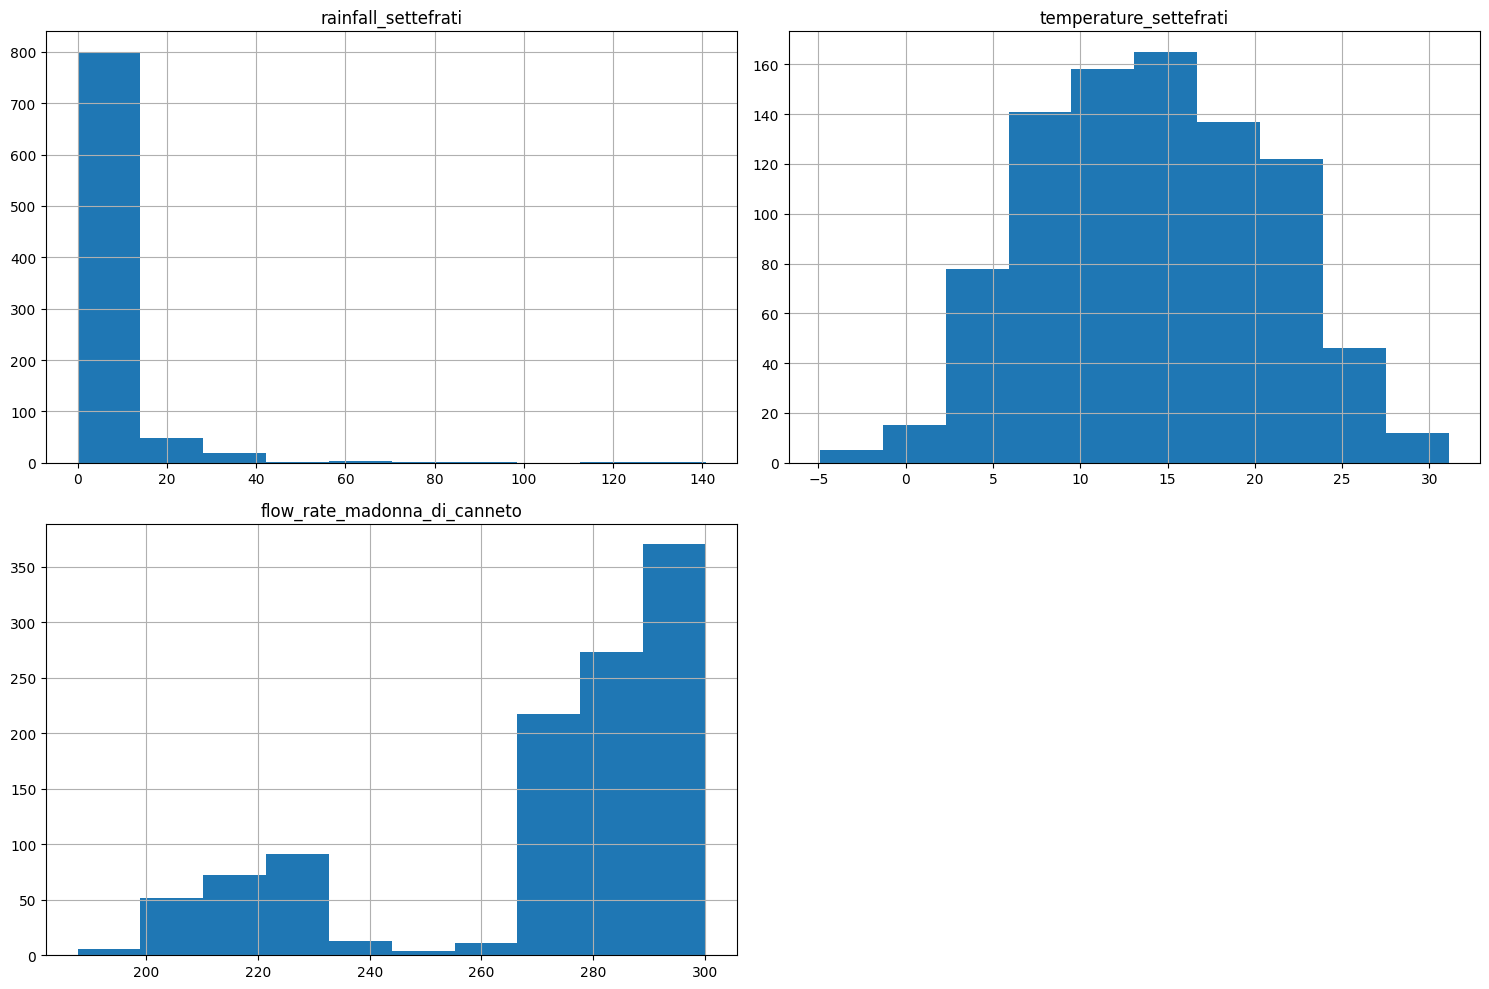

In [300]:
df_train.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

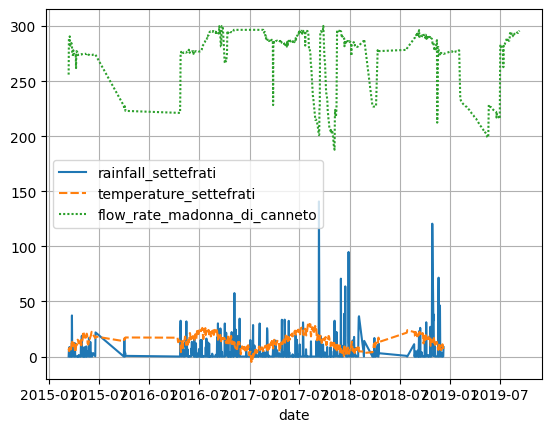

In [301]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

# Time Series  
Hmmm I will try a Time Series, but I think given the minimal seasonality it's gonna not be any good, I will also try a random forrest model

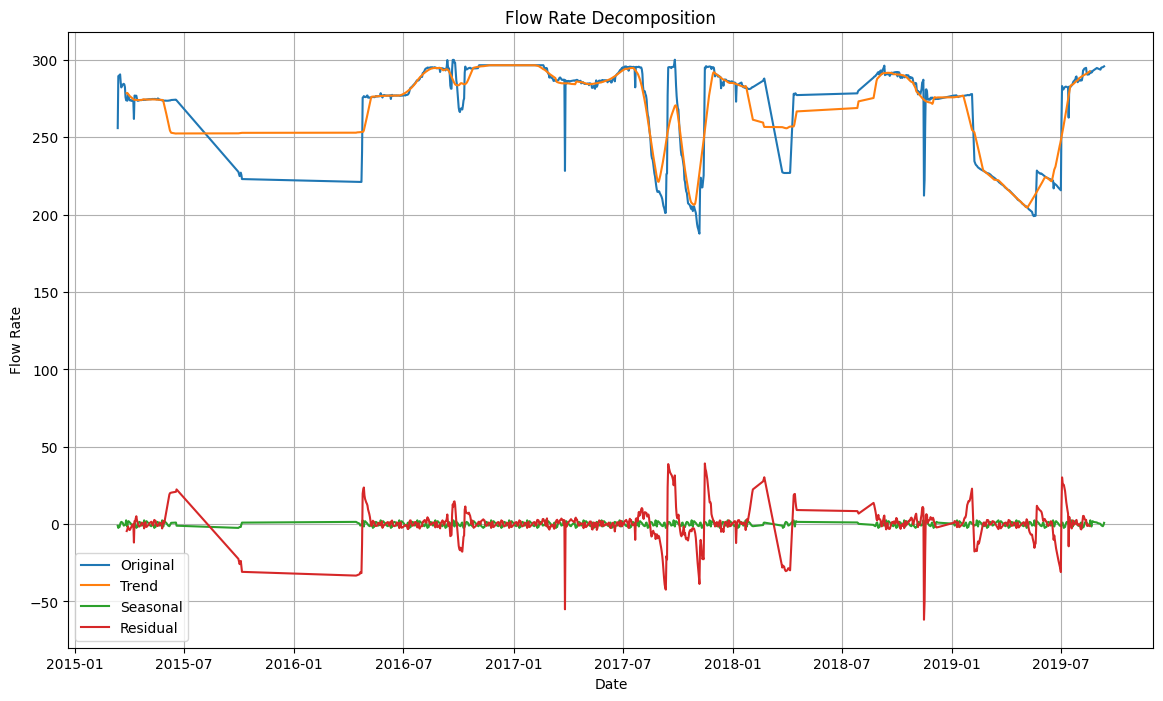

In [302]:
# Make sure index is datetime
df_train.index = pd.to_datetime(df_train.index)

# Seasonal decomposition
decomposition = seasonal_decompose(df_train['flow_rate_madonna_di_canneto'], period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot all components
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_train['flow_rate_madonna_di_canneto'], label='Original')
sns.lineplot(data=trend, label='Trend')
sns.lineplot(data=seasonal, label='Seasonal')
sns.lineplot(data=residual, label='Residual')
plt.xlabel('Date')
plt.ylabel('Flow Rate')
plt.title('Flow Rate Decomposition')
plt.legend()
plt.grid(True)
plt.show()


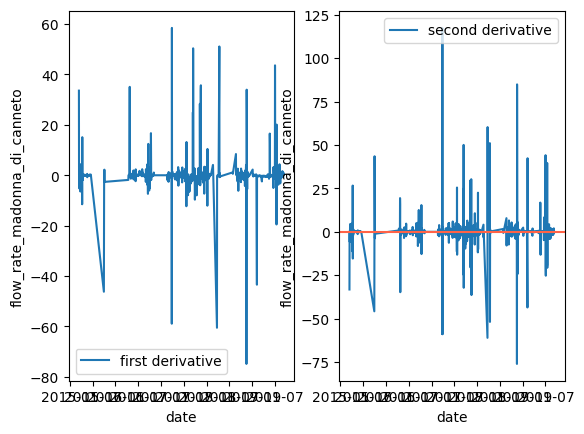

In [303]:
# d = stationarity, data points have no trend
fig,ax=plt.subplots(1,2)
sns.lineplot(df_train['flow_rate_madonna_di_canneto'].diff(),label='first derivative',ax=ax[0])
sns.lineplot(df_train['flow_rate_madonna_di_canneto'].diff().diff(),label='second derivative',ax=ax[1])
plt.axhline(0,color='tomato')
plt.show()

In [304]:
# alpha = 0.05 if the p value is above alpha then we can say that it is not stationary (it has trend)
# if p value < alpha then we can rule out that it is stationary  (it has no trend)
ad_fuller = adfuller(df_train['flow_rate_madonna_di_canneto'])
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -3.60
adf P Value: 0.01


In [305]:
ad_fuller = adfuller(df_train['flow_rate_madonna_di_canneto'].diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -32.47
adf P Value: 0.00


In [306]:
ad_fuller = adfuller(df_train['flow_rate_madonna_di_canneto'].diff().diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -12.31
adf P Value: 0.00


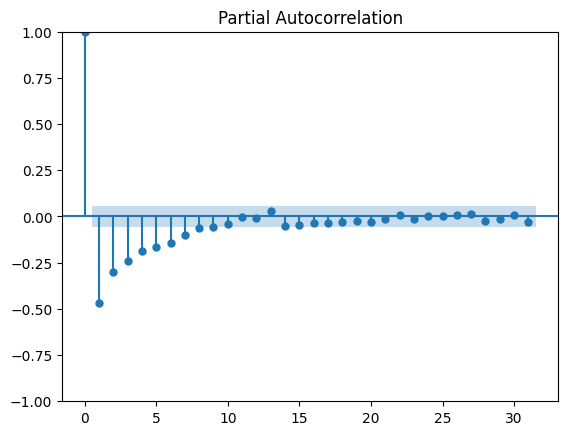

In [307]:
# value p is the autoregressive term - autoregressive = seasonality
plot_pacf(df_train['flow_rate_madonna_di_canneto'].diff().diff().dropna())
plt.show()

In [308]:
model = ARIMA(df_train['flow_rate_madonna_di_canneto'], order=(2,1,2))
fitted = model.fit()
n_steps = 278 # Use the length of the test set for forecast
forecast = fitted.forecast(steps=n_steps)

print(ts_arima.summary())

/workspaces/time_series_2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspaces/time_series_2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/workspaces/time_series_2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:     flow_rate_madonna_di_canneto   No. Observations:                 1109
Model:                           ARIMA(2, 1, 2)   Log Likelihood               -3577.087
Date:                          Tue, 06 May 2025   AIC                           7164.174
Time:                                  01:59:35   BIC                           7189.225
Sample:                                       0   HQIC                          7173.648
                                         - 1109                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4653      0.121     12.139      0.000       1.229       1.702
ar.L2         -0.8866      0.126     -7.054      0.

/workspaces/time_series_2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/workspaces/time_series_2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


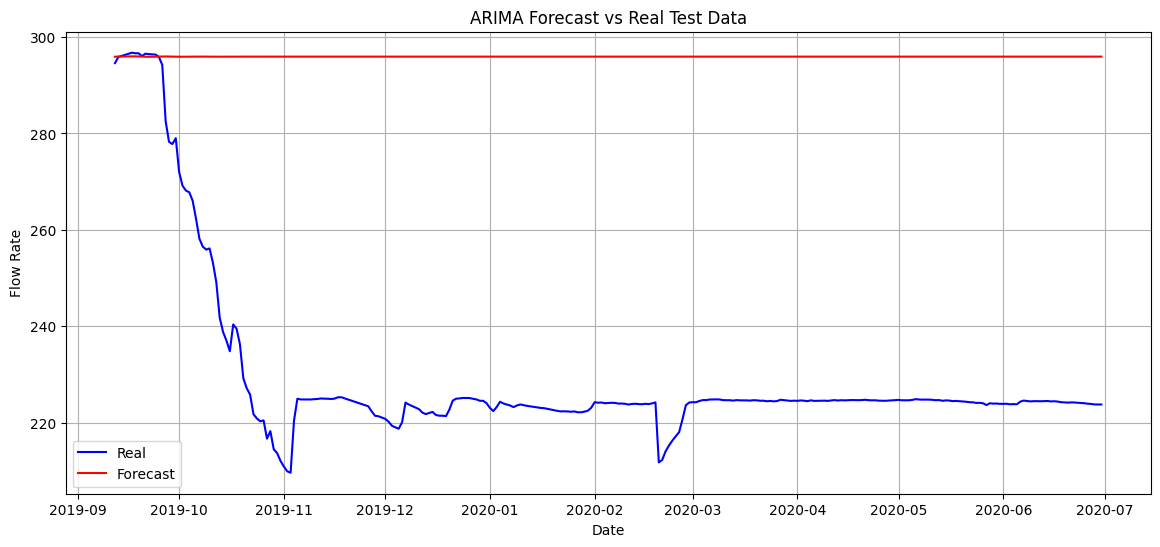

In [309]:
# Plot the forecast and real test data
plt.figure(figsize=(14, 6))
sns.lineplot(x=df_test.index, y=df_test['flow_rate_madonna_di_canneto'], label='Real', color='blue')

# Create a future index for the forecast values (same as df_test index)
forecast_index = df_test.index

# Plot the forecast values
sns.lineplot(x=forecast_index, y=forecast, label='Forecast', color='red')

plt.title('ARIMA Forecast vs Real Test Data')
plt.xlabel('Date')
plt.ylabel('Flow Rate')
plt.legend()
plt.grid(True)
plt.show()


In [310]:
print(forecast)
print(df_test['flow_rate_madonna_di_canneto'])


1109    295.921622
1110    295.965194
1111    295.996738
1112    296.004332
1113    295.987492
           ...    
1382    295.948375
1383    295.948375
1384    295.948375
1385    295.948375
1386    295.948375
Name: predicted_mean, Length: 278, dtype: float64
date
2019-09-12    294.596599
2019-09-13    295.880777
2019-09-17    296.757838
2019-09-18    296.649183
2019-09-19    296.639654
                 ...    
2020-06-26    223.919115
2020-06-27    223.861787
2020-06-28    223.764382
2020-06-29    223.766272
2020-06-30    223.752653
Name: flow_rate_madonna_di_canneto, Length: 278, dtype: float64


In [311]:
print(f"Test data ends at: {df_test.index[-1]}")
print(f"Forecast starts at: {forecast_series.index[0]}")

Test data ends at: 2020-06-30 00:00:00
Forecast starts at: 2020-07-01 00:00:00


## These predictions are notttt accurate at alll

In [312]:
#---------------

# Random Forest Regression
### Trying something new!

In [313]:
df_baking = df_baking.dropna(subset=['rainfall_settefrati', 'temperature_settefrati'])

# Feature engineering from date
df_baking['month'] = df_baking['date'].dt.month

df_baking['month'] = df_baking['date'].dt.month.astype('category')

df_baking['date'] = pd.to_datetime(df_baking['date'])
df_baking = df_baking.set_index('date')

# Define the split percentages
train_size = int(len(df_baking) * 0.8)
val_size = int(len(df_baking) * 0.1)
test_size = len(df_baking) - train_size - val_size

# Split the data
df_train_rf = df_baking[:train_size]
df_val_rf = df_baking[train_size:train_size+val_size]
df_test_rf = df_baking[train_size+val_size:]



# Check the shape of each split
print(f"Train set: {df_train_rf.shape}")
print(f"Validation set: {df_val_rf.shape}")
print(f"Test set: {df_test_rf.shape}")
df_train_rf.info()

Train set: (703, 4)
Validation set: (87, 4)
Test set: (89, 4)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 703 entries, 2015-03-13 to 2017-12-21
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   rainfall_settefrati           703 non-null    float64 
 1   temperature_settefrati        703 non-null    float64 
 2   flow_rate_madonna_di_canneto  703 non-null    float64 
 3   month                         703 non-null    category
dtypes: category(1), float64(3)
memory usage: 22.9 KB


Dropped null variables because random forest can't work with them

X_Train

In [314]:
X_train = df_train_rf[['rainfall_settefrati', 'temperature_settefrati']].copy()
y_train = df_train_rf['flow_rate_madonna_di_canneto'].copy()

X_val = df_val_rf[['rainfall_settefrati', 'temperature_settefrati']].copy()
y_val = df_val_rf['flow_rate_madonna_di_canneto'].copy()

X_test = df_test_rf[['rainfall_settefrati', 'temperature_settefrati']].copy()
y_test = df_test_rf['flow_rate_madonna_di_canneto'].copy()


X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 703 entries, 2015-03-13 to 2017-12-21
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rainfall_settefrati     703 non-null    float64
 1   temperature_settefrati  703 non-null    float64
dtypes: float64(2)
memory usage: 16.5 KB


### Encoding

In [315]:
X_train = pd.get_dummies(df_train_rf, columns=['month'], drop_first=True)
X_val = pd.get_dummies(df_val_rf, columns=['month'], drop_first=True)
X_test = pd.get_dummies(df_test_rf, columns=['month'], drop_first=True)


In [316]:
clf_rforest_p = Pipeline([
    ("powertransform", PowerTransformer()),
    ("rforest", RandomForestRegressor(random_state=2025))
])

clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        "rforest__max_depth": [3],
        "rforest__n_estimators": [20]
    },
    cv=5,
    scoring="neg_mean_squared_error",  # For regression, using a regression scoring metric
    n_jobs=-1
)

In [317]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [318]:
y_pred = model.predict(X_test)

# Evaluation metrics
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.10324294415731396
MSE: 0.08849091298709967
RMSE: 0.2974742223909488
R² Score: 0.9994238022701056


### these numbers are WAY too good to be true